In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [4]:
# INITIALISING PARAMETERS THAT WILL BE USED THROUGHOUT

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3  #RGB
EPOCHS = 50

<p style="color: purple; font-size: 25px;">Data Preprocessing</p>

In [5]:
# Using image_dataset_from_directory to create a dataset from the PlantVillage directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


<p style="color: green; font-size: 15px;">So these are the two main diseases a potato plant faces during its growth that is : Early Blight & Late Blight </p>

<p style="color: purple; font-size: 25px;">Let's Explore dataset now</p>

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 2 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]


<p style="color: green; font-size: 15px;">This (32,256,256,3) means each batch has 32 images of size 256 x 256 with 3 channels (RGB) and the below 0,1,2 for classes where : </p> 
<span style="color: green; font-size: 15px;">0 = Early Blight</span>
<span style="color: green; font-size: 15px;">1 = Late Blight</span>
<span style="color: green; font-size: 15px;">2 = Healthy</span>

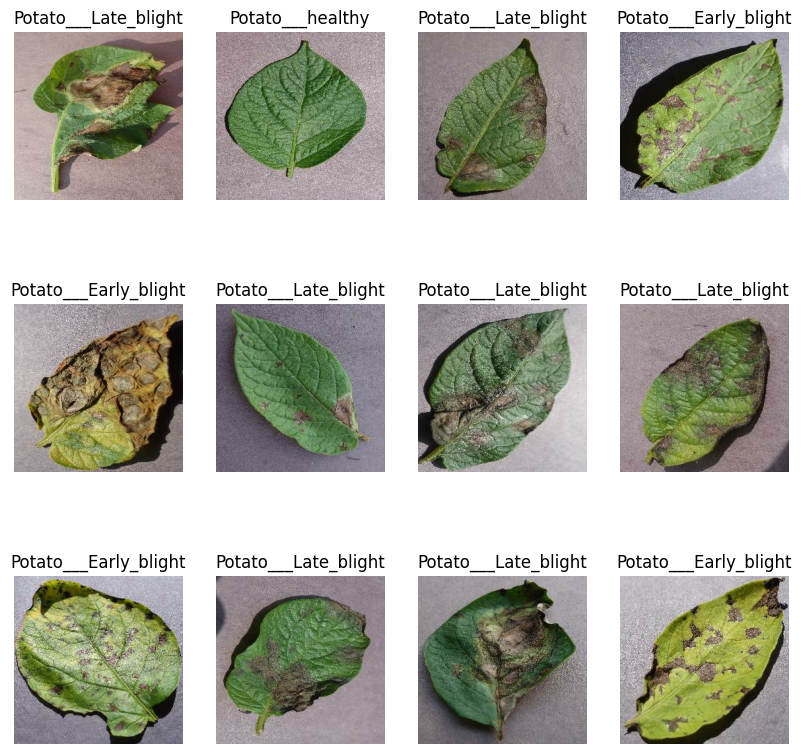

In [8]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<p style="color: purple; font-size: 25px;">Splitting dataset to train , test and validation set</p>

In [13]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    assert (train_split + val_split + test_split) == 1  # Train, val and test splits must sum to 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

<p style="color: purple; font-size: 25px;">Dataset Performance Optimizations (Cache, Shuffle, Prefetch) :</p>
<p style="color: green; font-size: 15px;">-> Improves data pipeline speed</p>
<p style="color: green; font-size: 15px;">-> Speeds up training significantly </p> 

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<p style="color: purple; font-size: 25px;">Image Preprocessing (Resize & Rescale)</p>  
<p style="color: green; font-size: 15px;">-> Resizes all images to a fixed size</p>
<p style="color: green; font-size: 15px;">-> Normalizes pixel values to [0, 1] </p> 
<p style="color: green; font-size: 15px;">-> Essential for CNN stability and performance </p> 

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

<p style="color: purple; font-size: 25px;">Data Augmentation Pipeline : </p>  
<p style="color: green; font-size: 15px;">-> Improves generalization</p>  
<p style="color: green; font-size: 15px;">-> Prevents overfitting</p>  
<p style="color: green; font-size: 15px;">-> Applies realistic transformation</p>  

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

<p style="color: purple; font-size: 25px;">Building and training CNN Model</p>  

In [23]:
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation = 'relu'),

    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

C:\Users\dhruv\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 32)         │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,411 (505.51 KB)

 Trainable params: 129,411 (505.51 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step - accuracy: 0.4936 - loss: 0.9200 - val_accuracy: 0.4948 - val_loss: 0.8077
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.6331 - loss: 0.8148 - val_accuracy: 0.6406 - val_loss: 0.7590
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.7390 - loss: 0.6068 - val_accuracy: 0.8281 - val_loss: 0.5032
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 462ms/step - accuracy: 0.8189 - loss: 0.4374 - val_accuracy: 0.8438 - val_loss: 0.3960
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 524ms/step - accuracy: 0.8785 - loss: 0.3199 - val_accuracy: 0.8490 - val_loss: 0.3484
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 530ms/step - accuracy: 0.8802 - loss: 0.2988 - val_accuracy: 0.8854 - val_loss: 0.3354
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 546ms/step - accuracy: 0.8981 - loss: 0.2626 - val_accuracy: 0.8802 - val_loss: 0.3036
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 541ms/step - accuracy: 0.9149 - loss: 0.2217 - val_accu

In [27]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9766 - loss: 0.0434


[0.043378349393606186, 0.9765625]

<p style="color: purple; font-size: 25px;">Performing Predictions on Sample Images</p>  

In [28]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


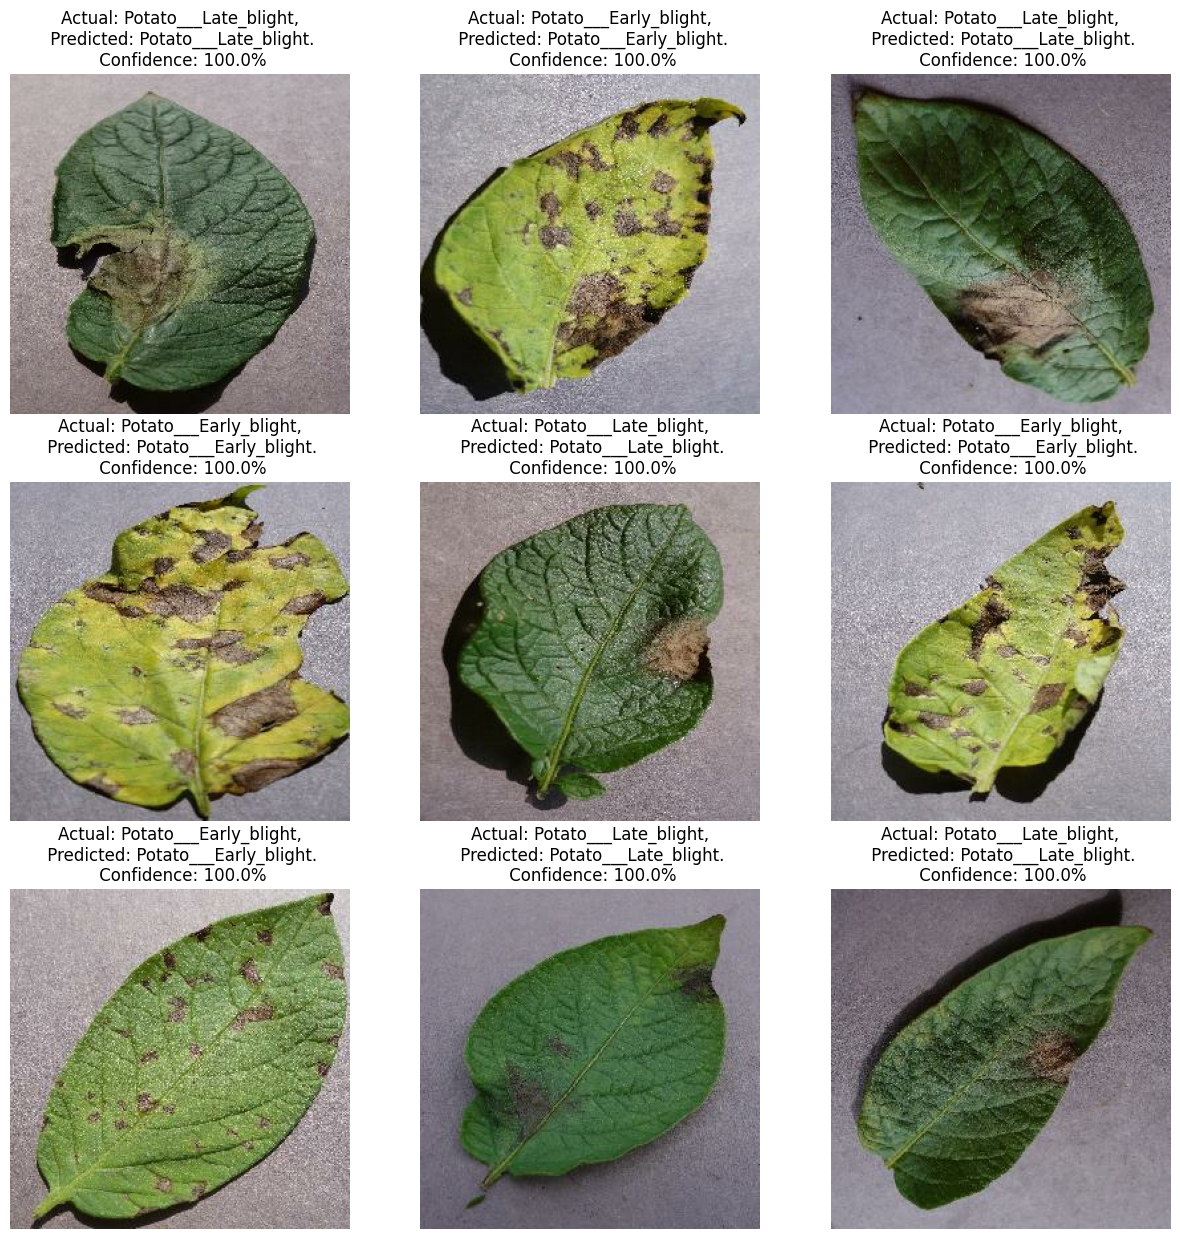

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<p style="color: purple; font-size: 25px;">Saving the Model with version</p>  


In [32]:
model.save("../potatoes.h5")